In [ ]:
# @title Model Set up and 1 epoch of fine-tuning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
import numpy as np
import types
import math


# ---------- Dataset Parent Class ----------
class BaseDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        raise NotImplementedError

    def __getitem__(self, idx):
        raise NotImplementedError


# ---------- CIFAR10 Child Class ----------
class CIFAR10Dataset(BaseDataset):
    def __init__(self, root='./data', train=True, download=True, transform=None):
        super().__init__(transform)
        self.dataset = CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


# ---------- Model Parent Class ----------
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = None

    def forward(self, x):
        return self.model(x)


# ---------- ViT Child Class ----------
class ViTModel(BaseModel):
    def __init__(self, model_name='vit_b_16', num_classes=10, pretrained=True):
        super().__init__()
        if model_name == 'vit_b_16':
            # Load pretrained ViT-B/16
            self.model = vit_b_16(weights='DEFAULT')
        else:
            raise ValueError(f"Unsupported model name: {model_name}")
        # Replace classification head
        in_features = self.model.heads.head.in_features
        self.model.heads.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


# ---------- Attention Extractor ----------
class AttentionExtractor:
    def __init__(self, model):
        self.model = model
        self.attentions = []
        # register hooks on MultiheadAttention modules
        for name, module in self.model.named_modules():
            if isinstance(module, nn.MultiheadAttention):
                module.register_forward_hook(self._hook(name))
                print(f"Registered hook for {name}")

    def _hook(self, name):
        def hook(module, inp, out):
            # out: (attn_output, attn_weights)
            attn_weights = out[1] if isinstance(out, tuple) else None
            if attn_weights is not None:
                self.attentions.append((name, attn_weights.detach().cpu()))
        return hook

    def clear(self):
        self.attentions = []

    def get(self):
        return self.attentions


# ---------- Training Method ----------
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


# ---------- Main Pipeline ----------
#if __name__ == '__main__':
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ImageNet preprocessing
resize_size = 256
crop_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),  # scale to [0,1]
    transforms.Normalize(mean=mean, std=std),
])

# Load CIFAR-10 (using test split for efficiency)
batch_size = 64
train_ds = CIFAR10Dataset(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# get test data
test_ds = CIFAR10Dataset(root='./data', train=False, download=True, transform=transform)

# Initialize and patch model
model = ViTModel(model_name='vit_b_16', num_classes=10, pretrained=True)
model.to(device)

# Monkey‑patch MultiheadAttention to get per‑head weights
_orig_mha_forward = nn.MultiheadAttention.forward
def forward_with_weights(self, *args, **kwargs):
    # force both flags
    kwargs['need_weights'] = True
    kwargs['average_attn_weights'] = False
    return _orig_mha_forward(self, *args, **kwargs)

for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        module.forward = types.MethodType(forward_with_weights, module)
        print(f"Patched MHA in {name}")


# Optimizer & Loss
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

# Fine-tune one epoch
loss, acc = train(model, train_loader, optimizer, criterion, device)
print(f"Training Loss: {loss:.4f}, Accuracy: {acc:.4%}")


Patched MHA in model.encoder.layers.encoder_layer_0.self_attention
Patched MHA in model.encoder.layers.encoder_layer_1.self_attention
Patched MHA in model.encoder.layers.encoder_layer_2.self_attention
Patched MHA in model.encoder.layers.encoder_layer_3.self_attention
Patched MHA in model.encoder.layers.encoder_layer_4.self_attention
Patched MHA in model.encoder.layers.encoder_layer_5.self_attention
Patched MHA in model.encoder.layers.encoder_layer_6.self_attention
Patched MHA in model.encoder.layers.encoder_layer_7.self_attention
Patched MHA in model.encoder.layers.encoder_layer_8.self_attention
Patched MHA in model.encoder.layers.encoder_layer_9.self_attention
Patched MHA in model.encoder.layers.encoder_layer_10.self_attention
Patched MHA in model.encoder.layers.encoder_layer_11.self_attention
Training Loss: 0.1733, Accuracy: 94.9440%


In [ ]:
#@title Extract attentions
# Select samples and extract attention
# set numpy seed
np.random.seed(42) # set numpy seed
# draw 10 random integers
attn_ds = test_ds
sample_ids = np.random.randint(0, len(attn_ds), 10) # [6, 972, 233, 1927] #[0, 5, 10]
print(sample_ids)

subset = Subset(attn_ds, sample_ids)
sub_loader = DataLoader(subset, batch_size=1, shuffle=False)

attn_ext = AttentionExtractor(model)
attn_ext.clear()
images = []
model.eval()
with torch.no_grad():
    for img, _ in sub_loader:
        images.append(img.squeeze(0))
        _ = model(img.to(device))
attentions = attn_ext.get()

[7270  860 5390 5191 5734 6265  466 4426 5578 8322]
Registered hook for model.encoder.layers.encoder_layer_0.self_attention
Registered hook for model.encoder.layers.encoder_layer_1.self_attention
Registered hook for model.encoder.layers.encoder_layer_2.self_attention
Registered hook for model.encoder.layers.encoder_layer_3.self_attention
Registered hook for model.encoder.layers.encoder_layer_4.self_attention
Registered hook for model.encoder.layers.encoder_layer_5.self_attention
Registered hook for model.encoder.layers.encoder_layer_6.self_attention
Registered hook for model.encoder.layers.encoder_layer_7.self_attention
Registered hook for model.encoder.layers.encoder_layer_8.self_attention
Registered hook for model.encoder.layers.encoder_layer_9.self_attention
Registered hook for model.encoder.layers.encoder_layer_10.self_attention
Registered hook for model.encoder.layers.encoder_layer_11.self_attention


In [ ]:
# check attentions length (should be = 12 (num of layers) * 4 (num samples) = 48)
#len(attentions)  # attentions[0][1].shape -> torch.Size([1, 12, 197, 197])

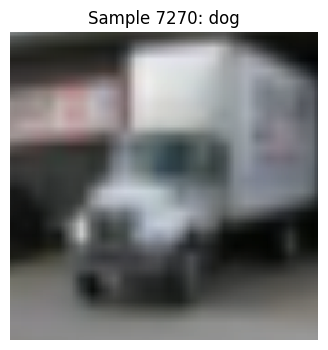

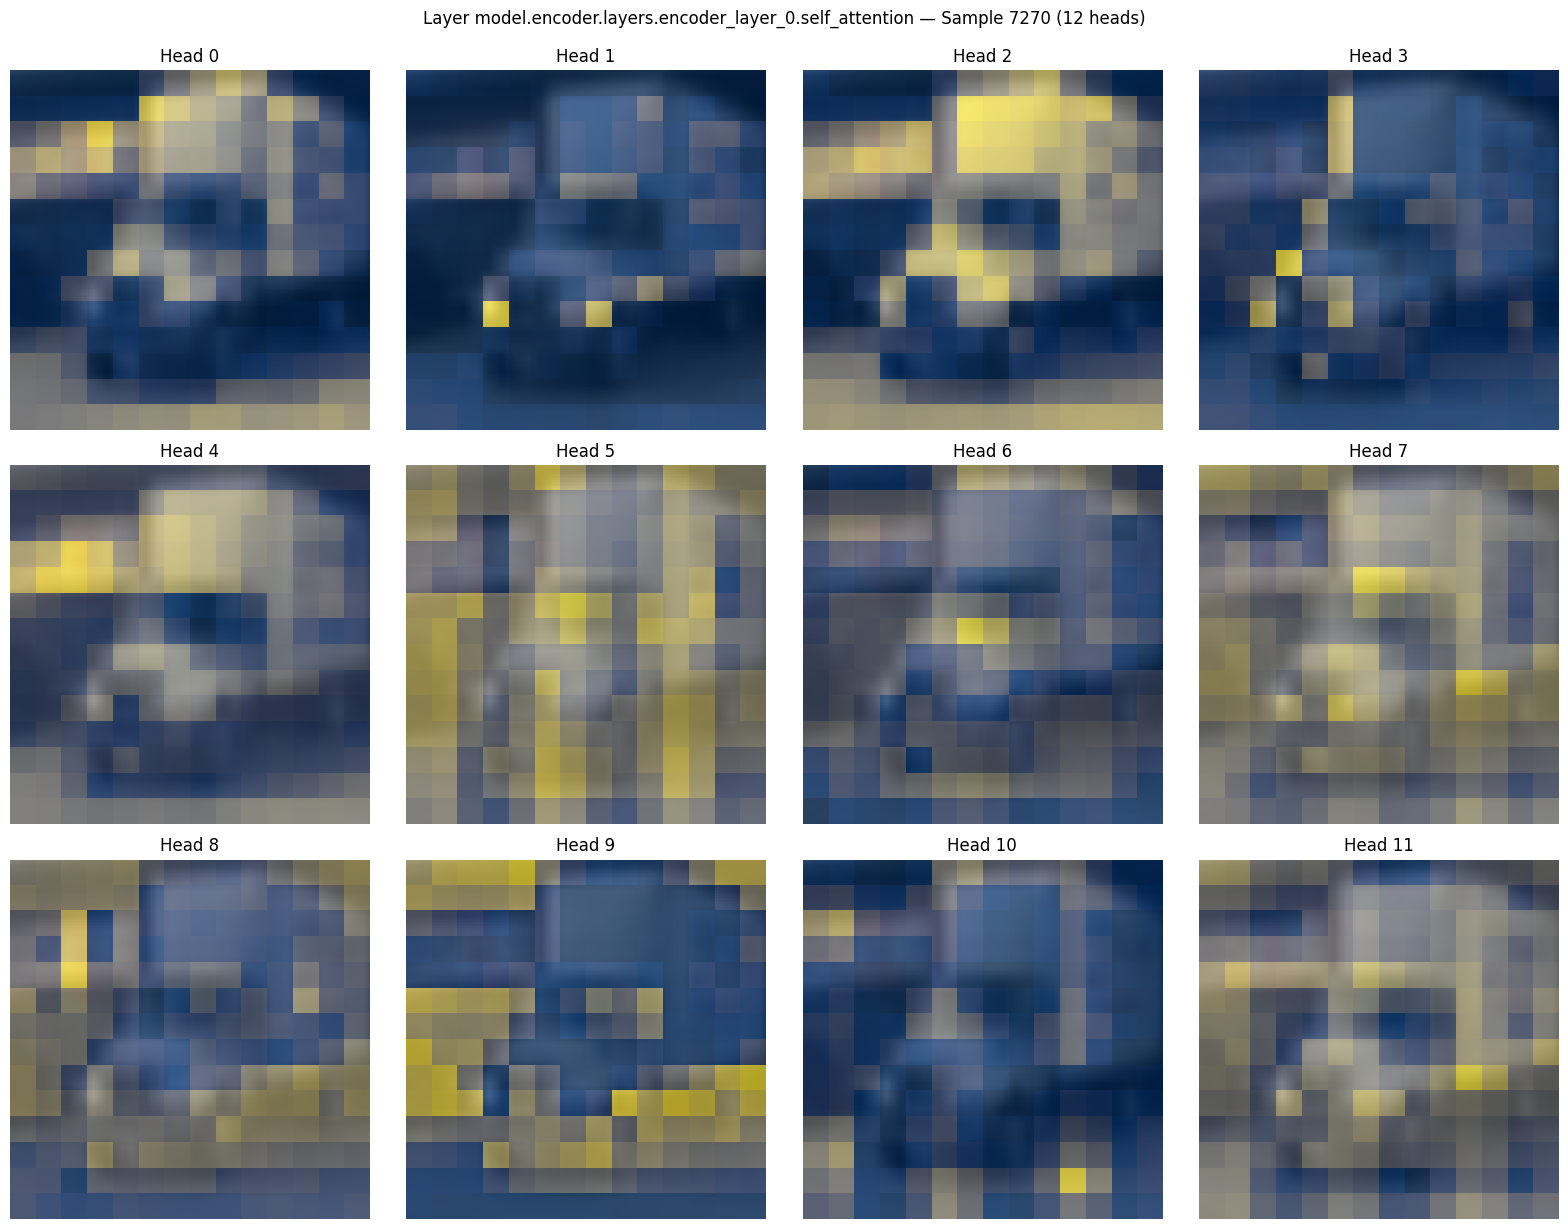

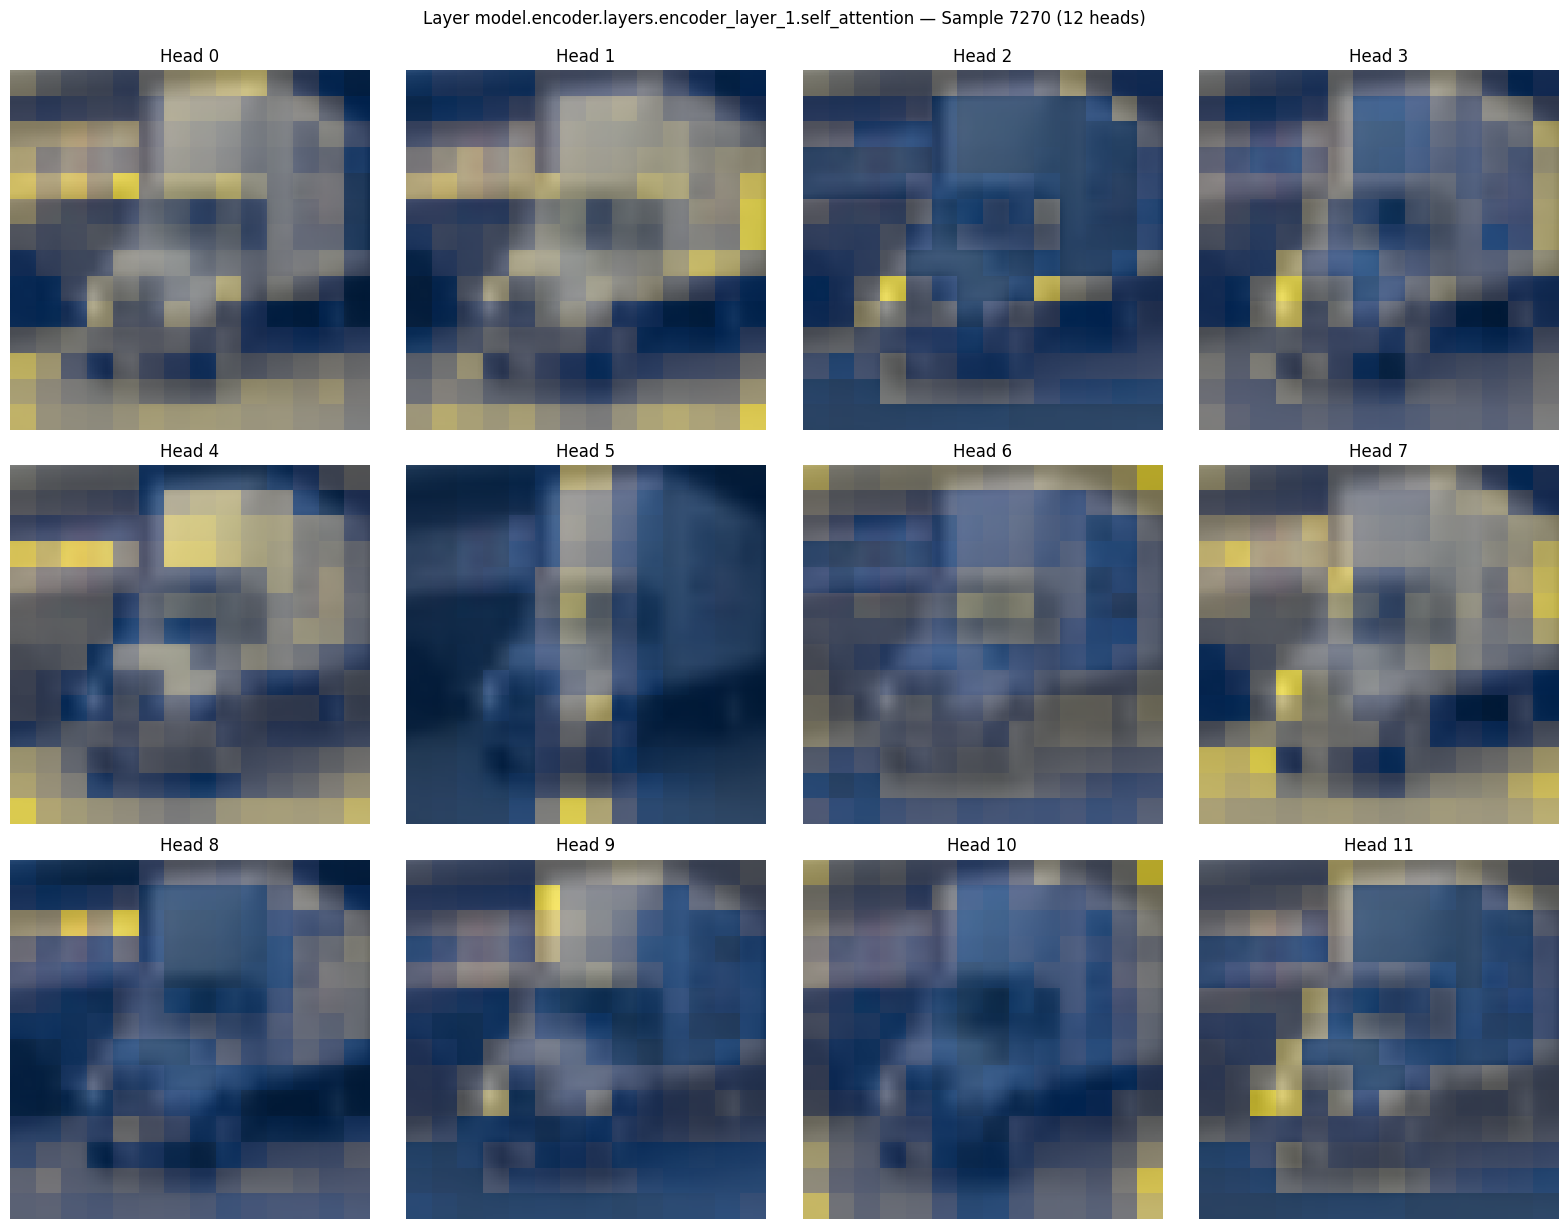

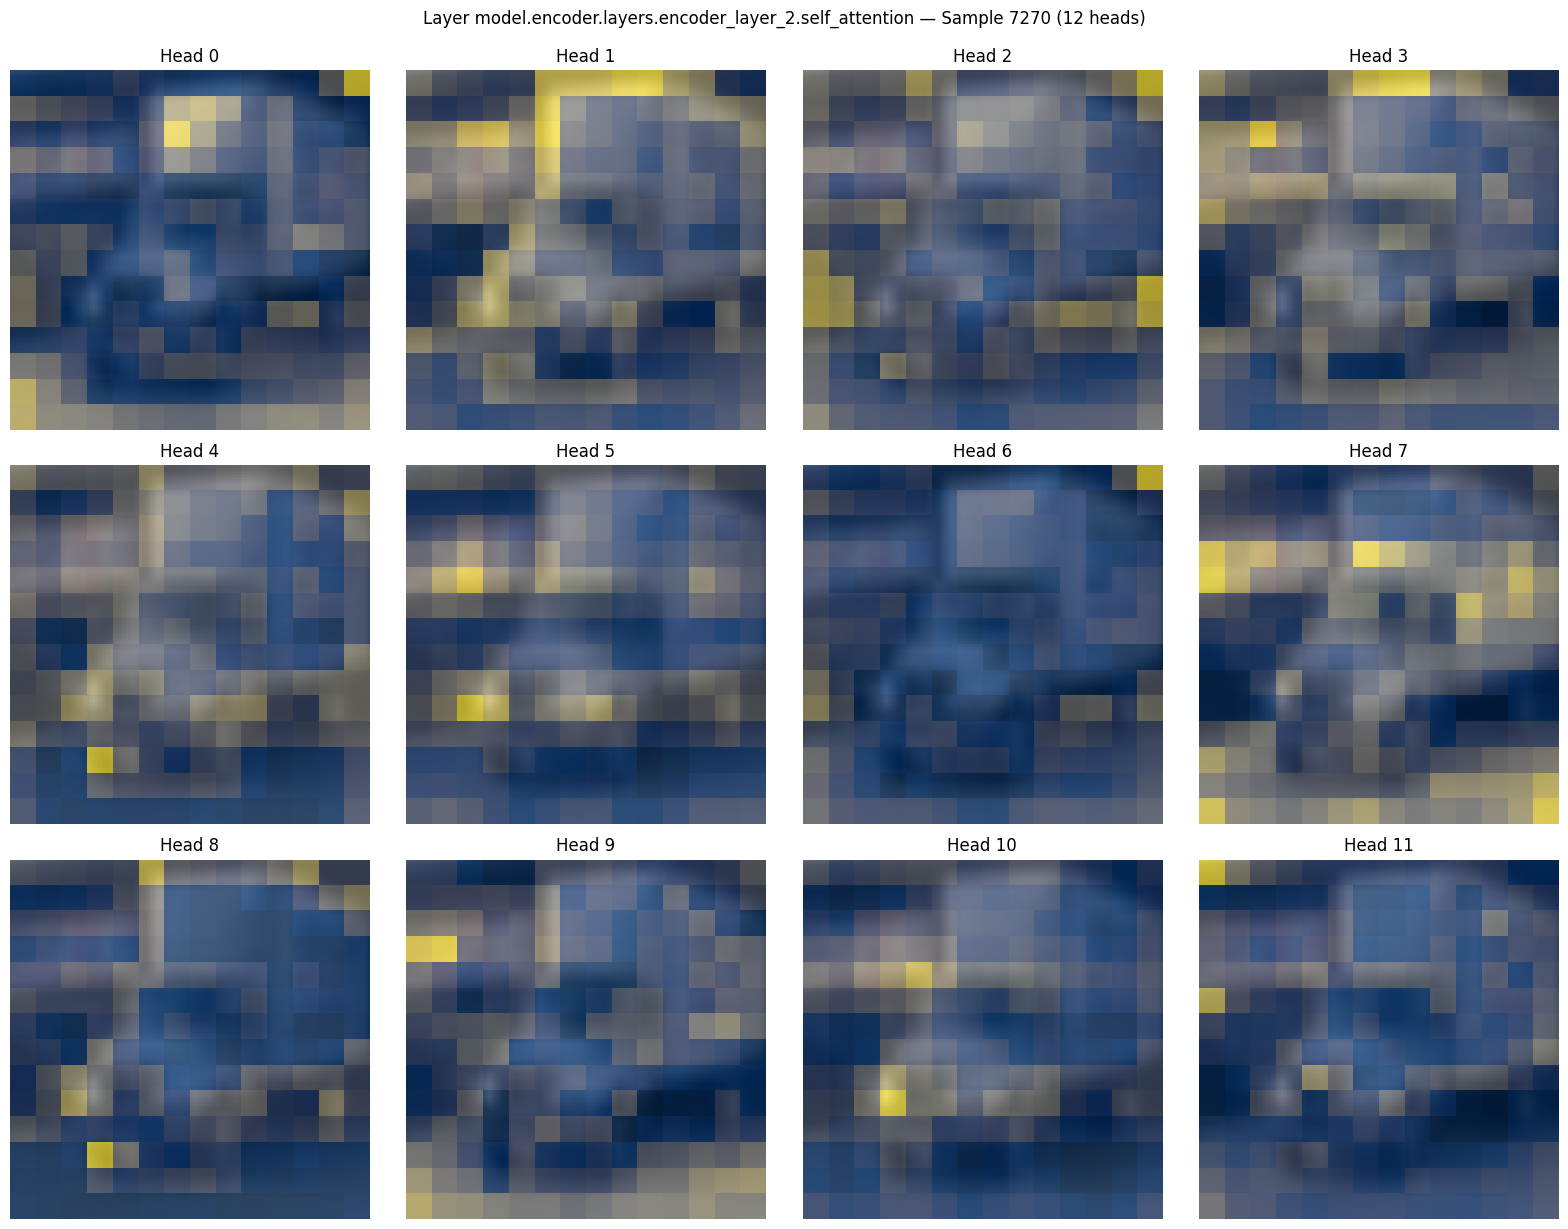

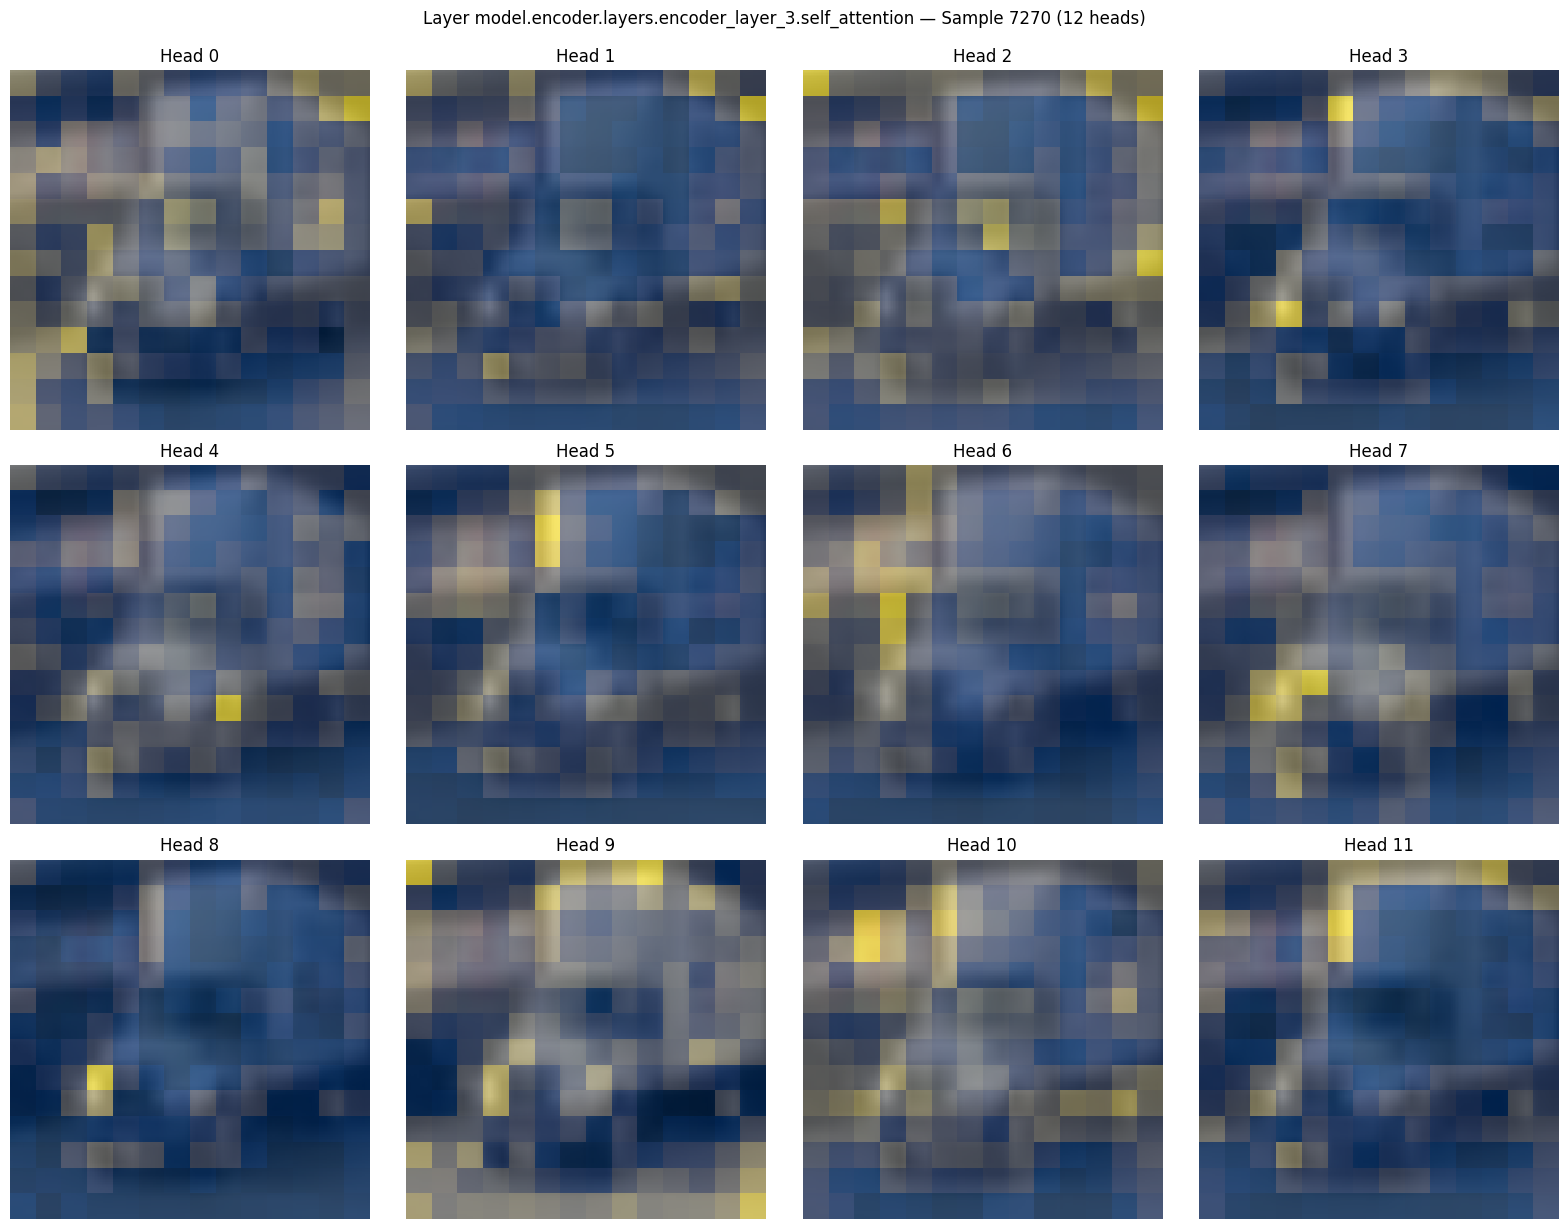

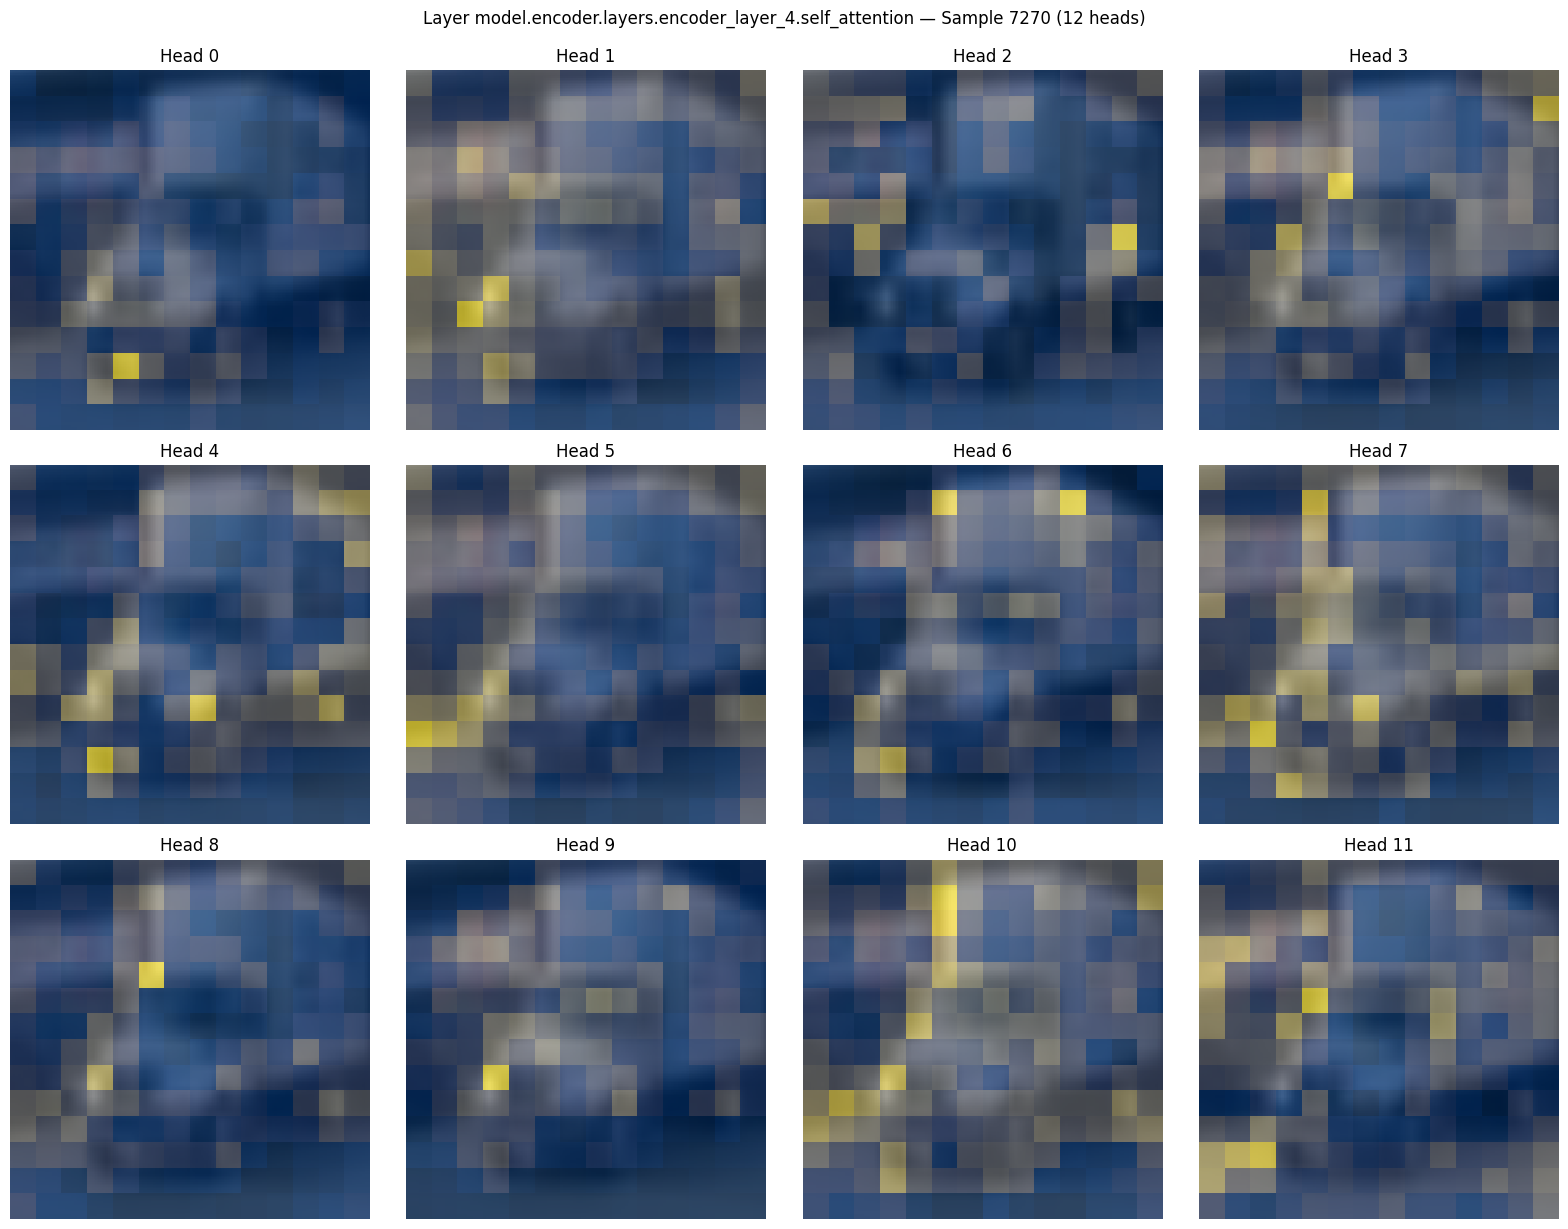

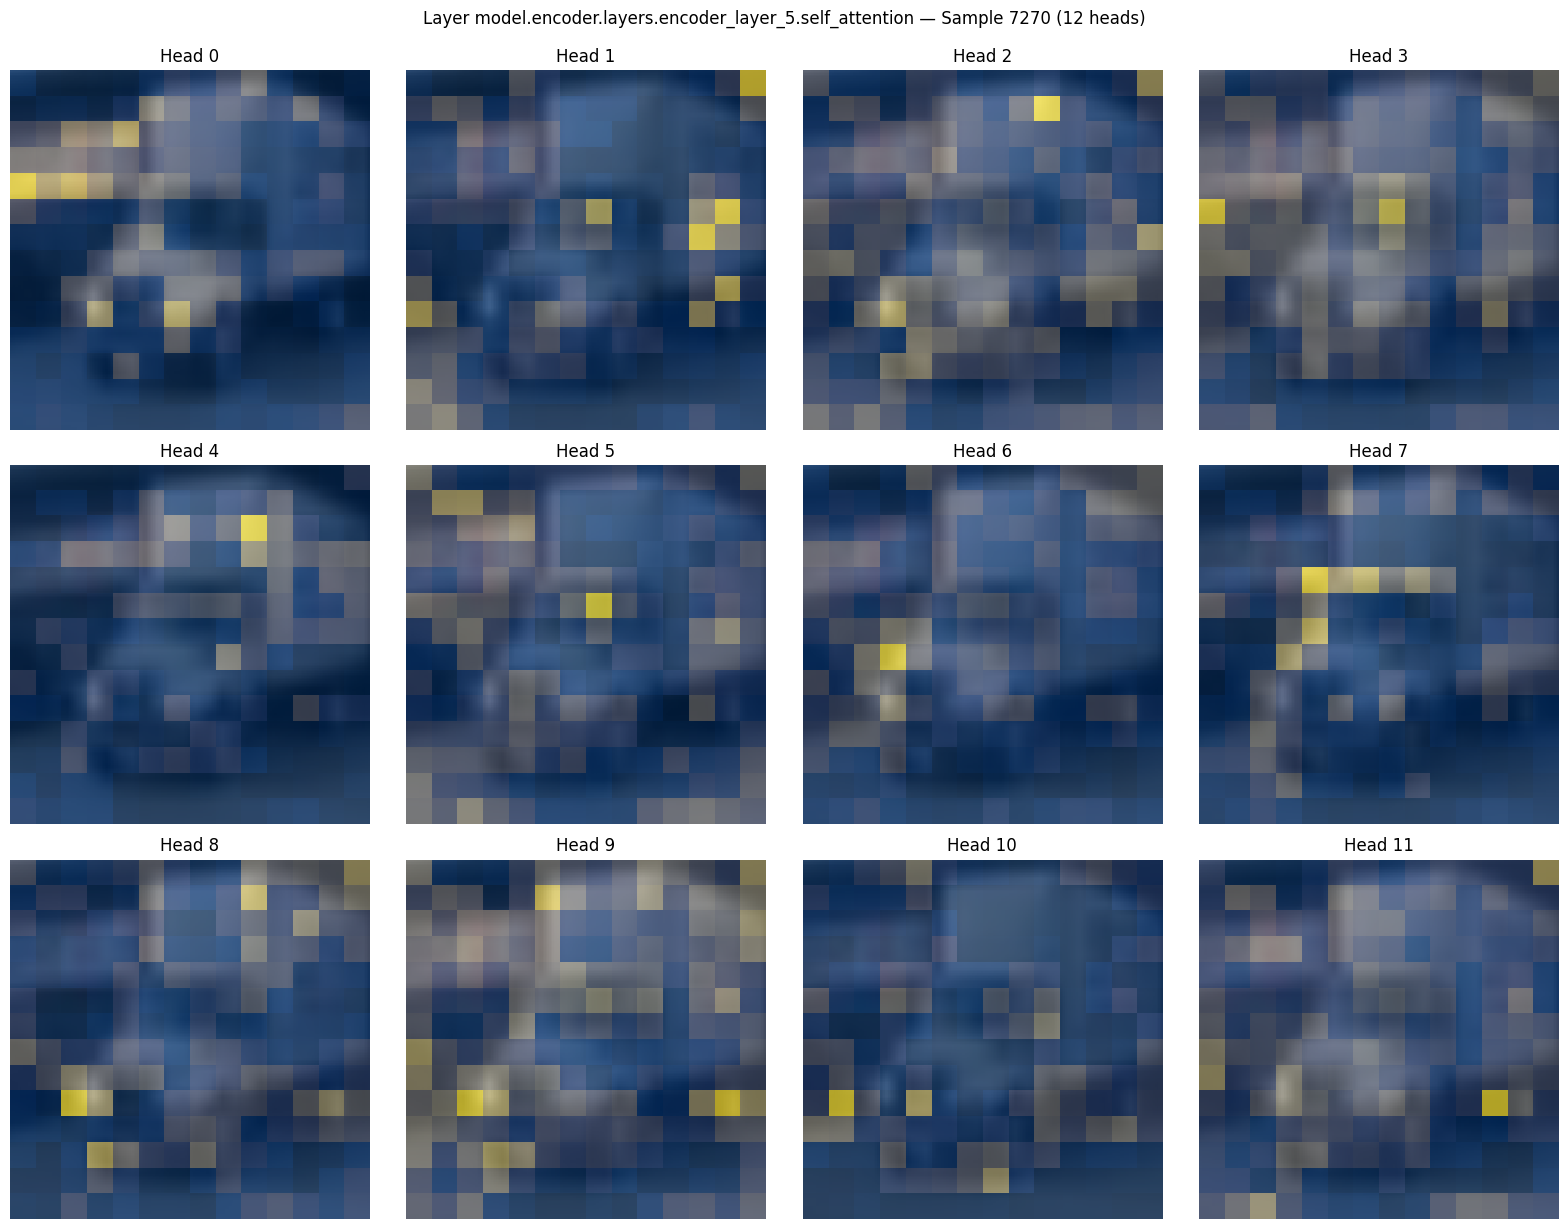

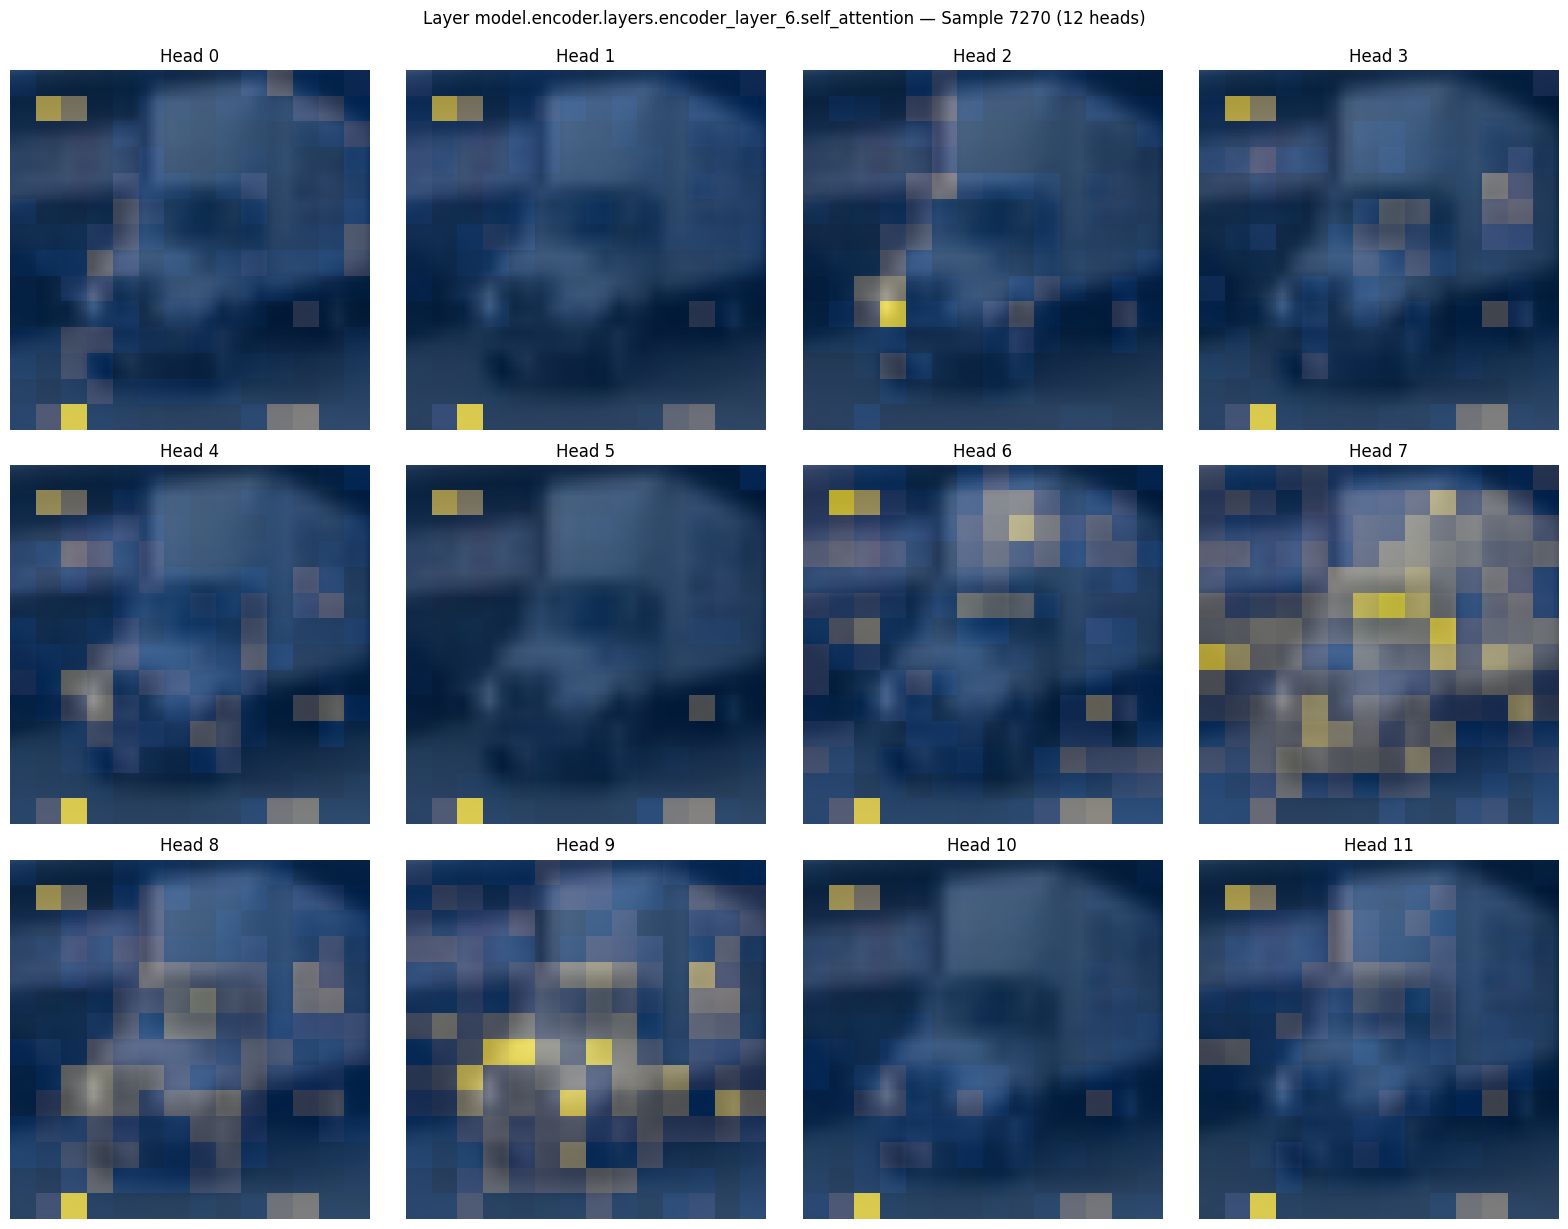

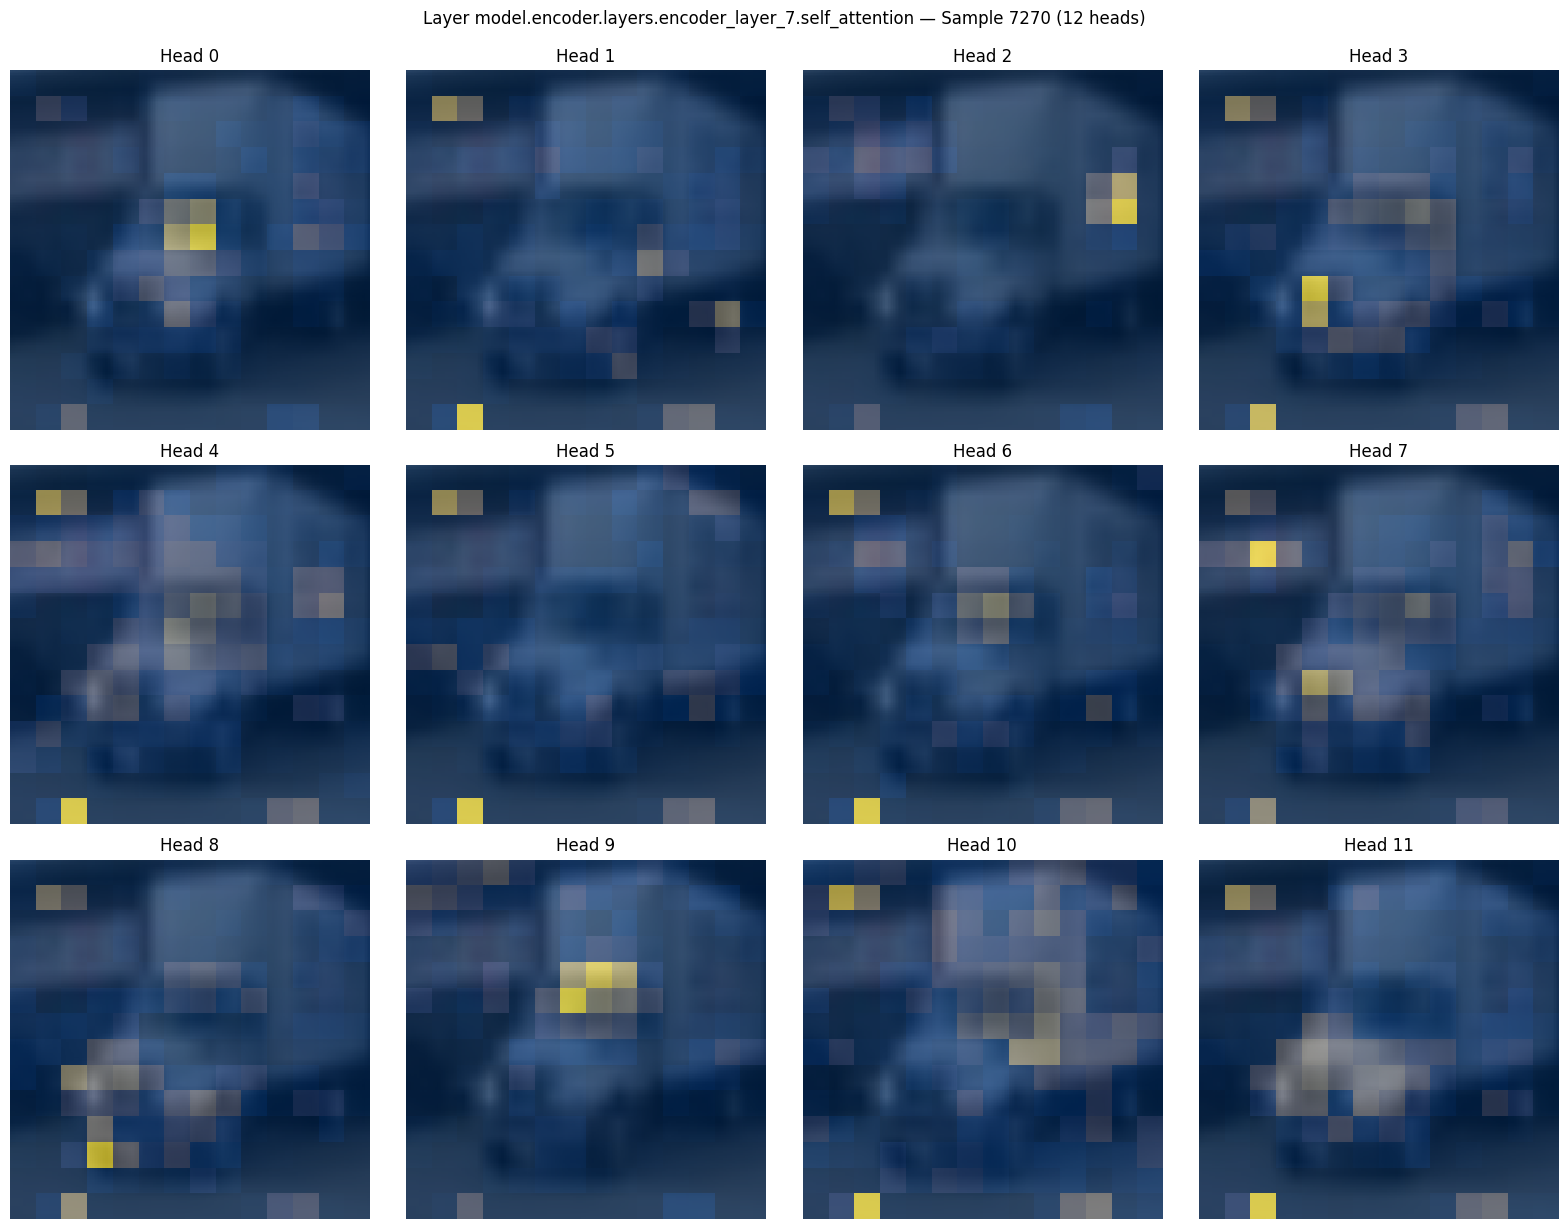

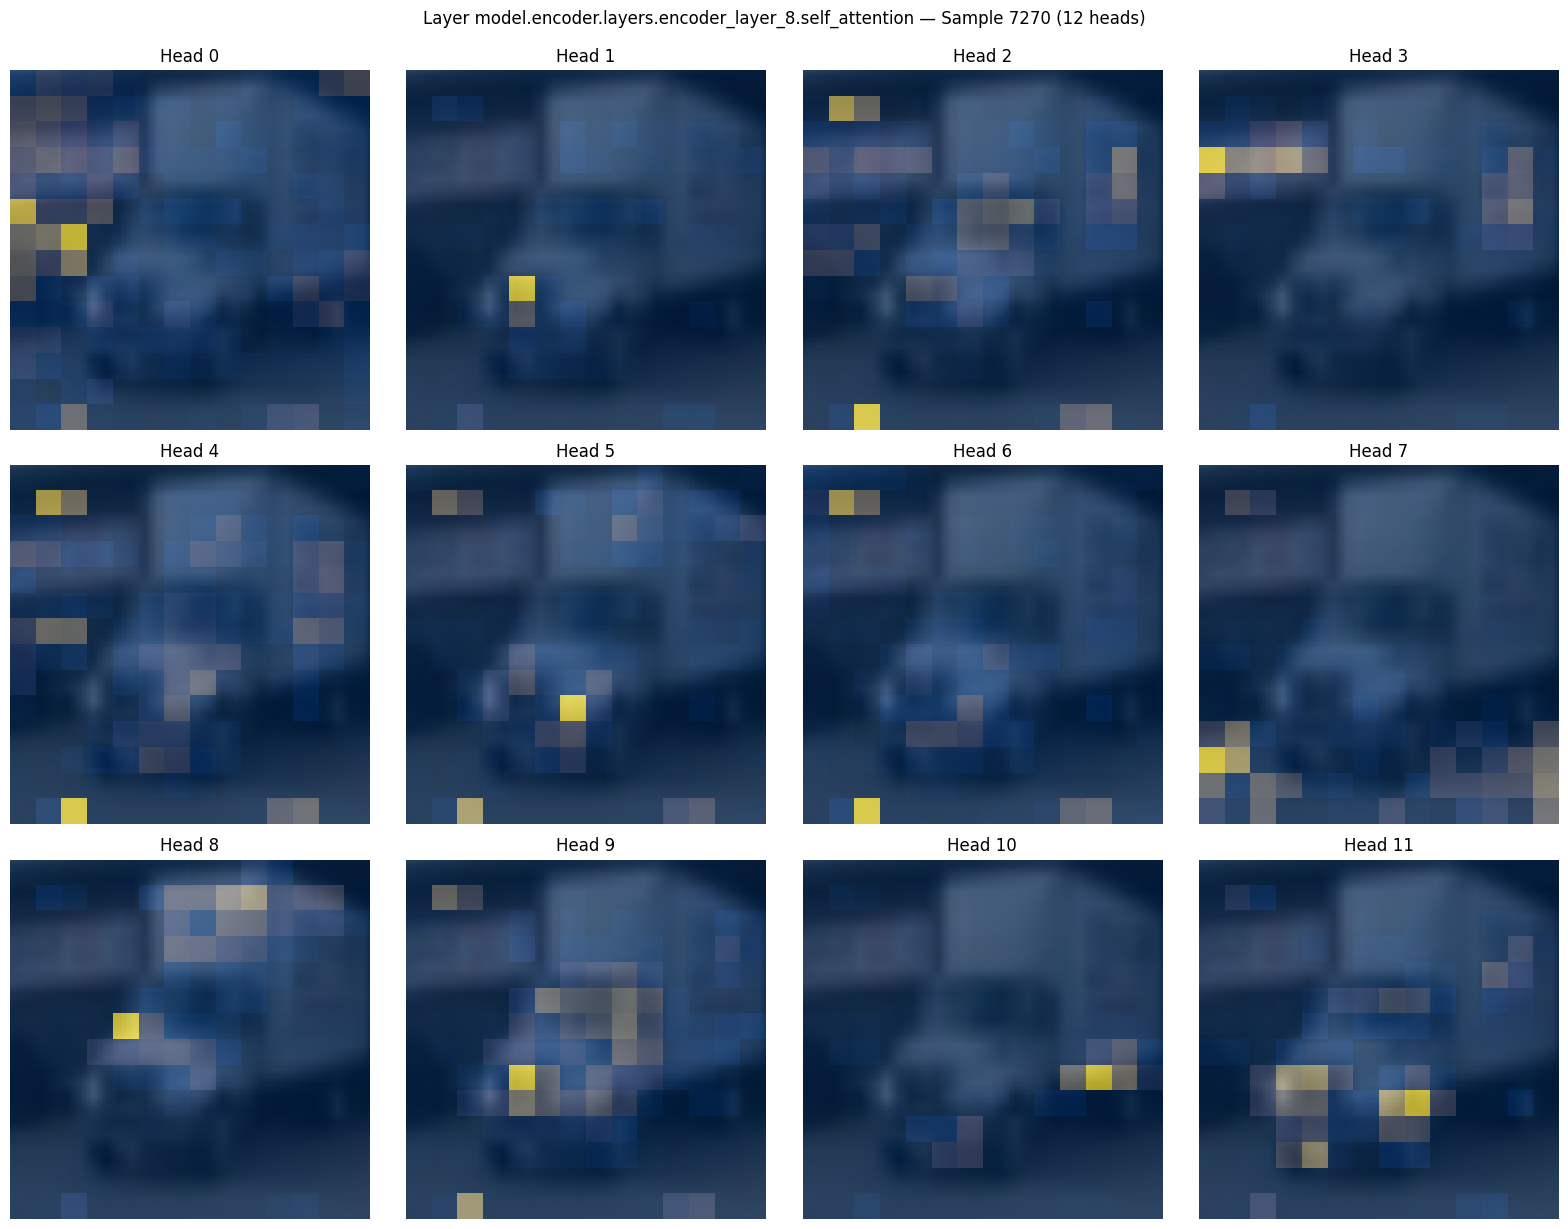

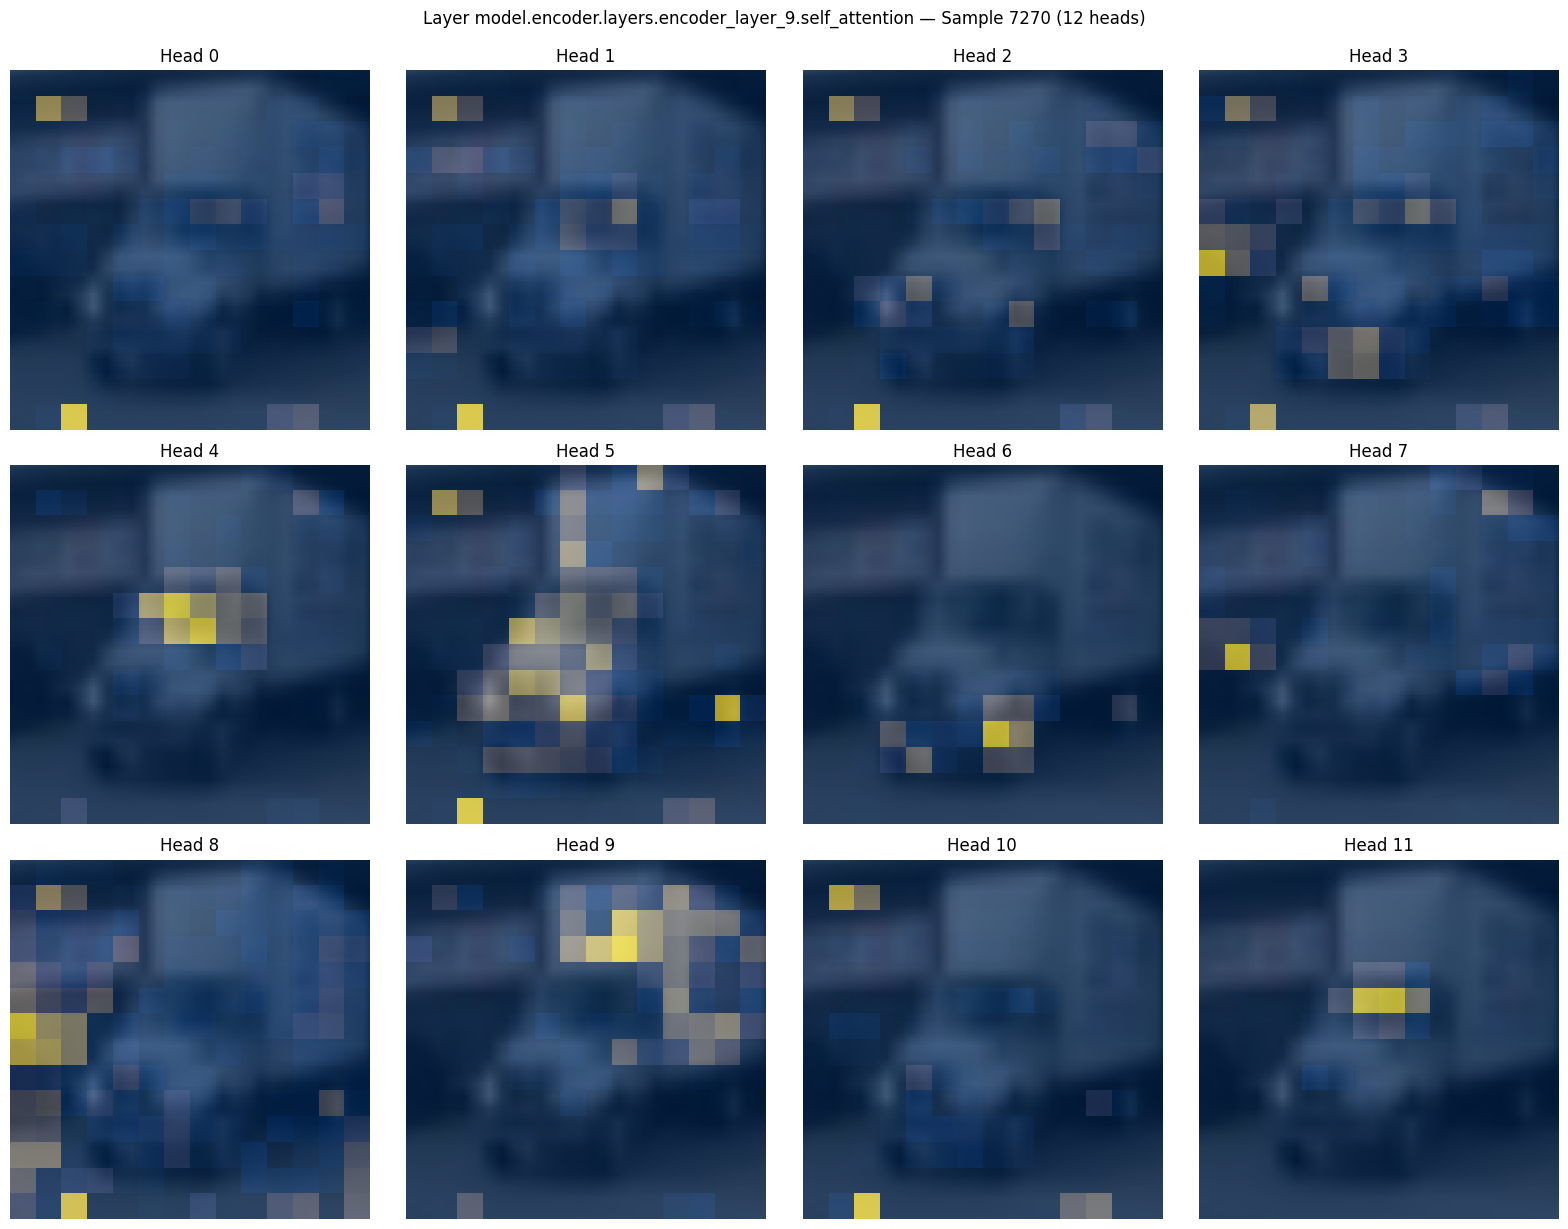

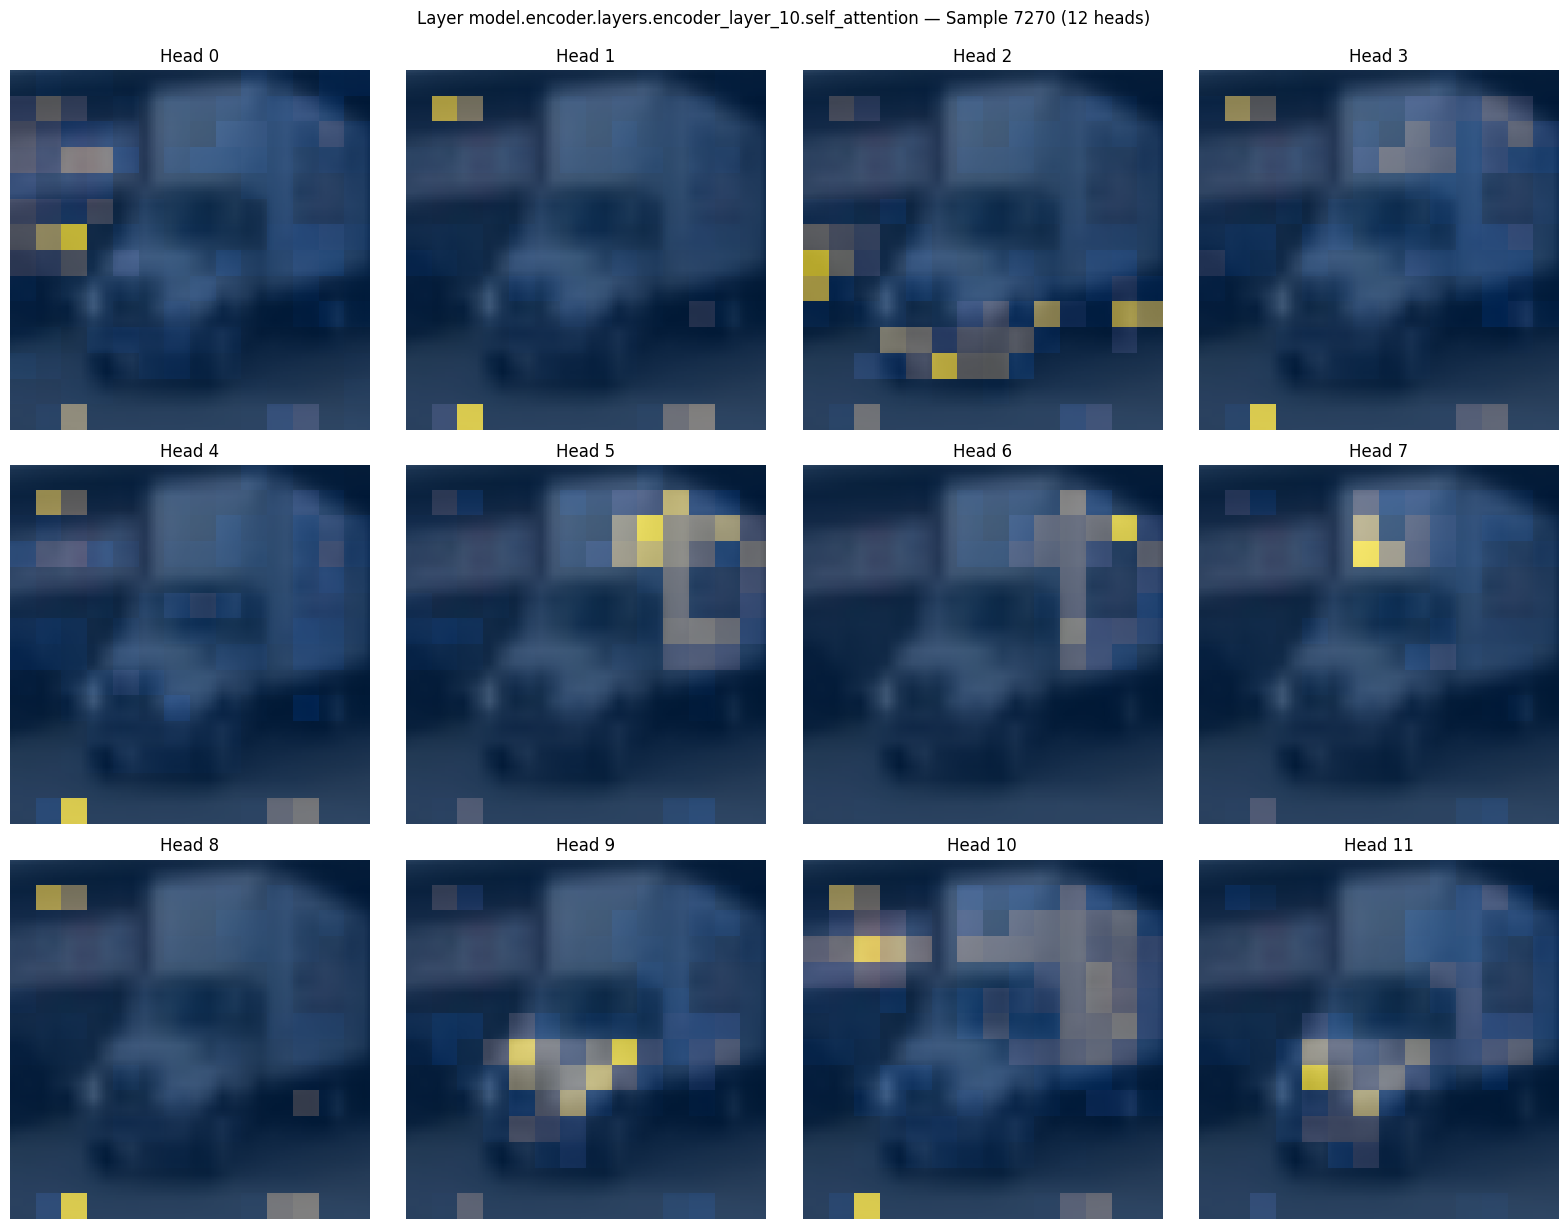

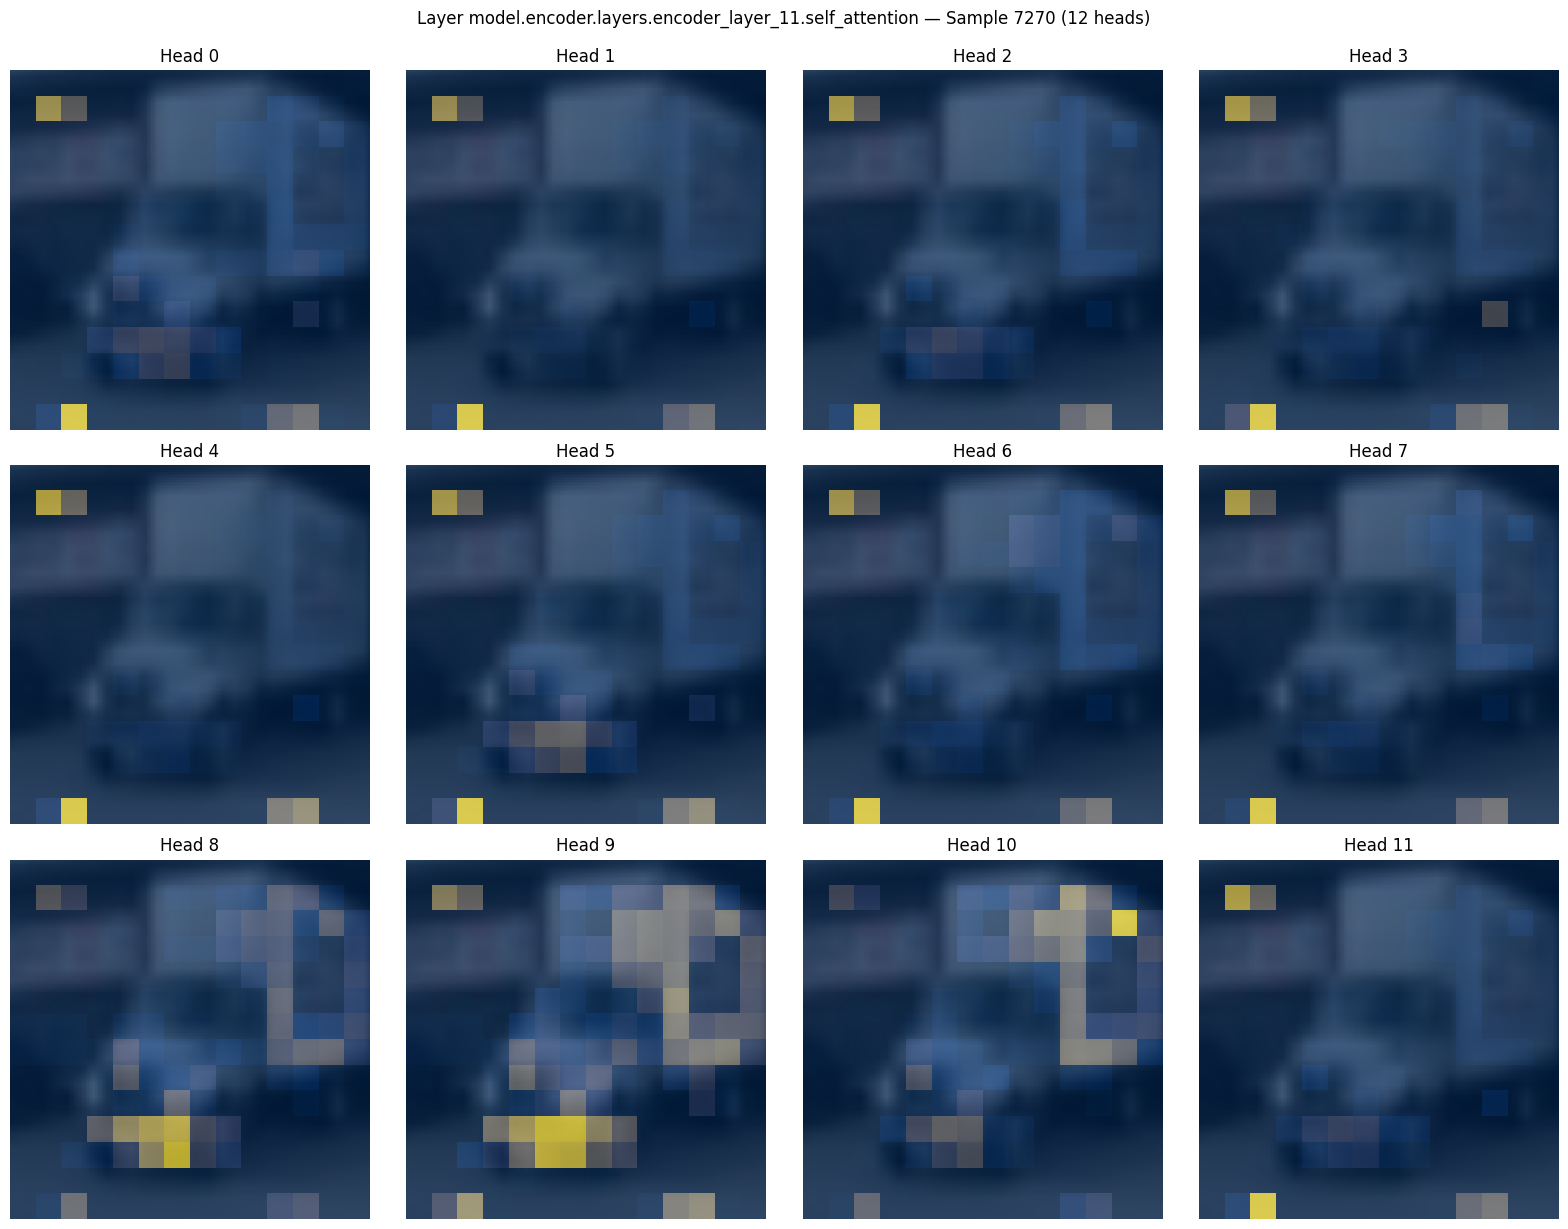

In [ ]:
# @title Plot the attention maps for the CLS
# This step is to check that the model is indeed working as expected

# --- 1) Build an “unnormalize” transform to invert (x - mean)/std ---
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std =[1/s   for s     in std]
)

# pick the sample you want to visualise
sample_idx = 0
sample_id  = sample_ids[sample_idx]


# 1) Reverse normalization
img_norm   = images[sample_idx]                    # Tensor [3,224,224]
img_unnorm = unnormalize(img_norm).clamp(0,1)      # back to [0,1]
orig_img   = transforms.ToPILImage()(img_unnorm)

# The original sample_id might be out of range for CIFAR-10 classes (0-9).
# Using the label from the dataset directly ensures it's within the valid range.
_, label = attn_ds.dataset[sample_id]
label_name = attn_ds.dataset.classes[label]   # e.g. 'cat', 'dog', etc.


# 3) Plot original image + title with label
plt.figure(figsize=(4,4))
plt.imshow(orig_img, interpolation='nearest')
plt.title(f"Sample {sample_id}: {label_name}")
plt.axis('off')
plt.show()

# Plot CLS attention maps
for lay_num in range(12):
    # --- 2) Grab one layer’s attention: (1, num_heads, 197,197) ---

    layer_number = lay_num # otherwise can specify

    layer_name, attn = attentions[sample_idx*12 + layer_number]
    attn = attn.squeeze(0)    # → (num_heads, 197,197)
    num_heads = attn.size(0)

    # --- 3) Plot each head in a dynamic grid, with nearest‐neighbor for solid patches ---
    cols = 4
    rows = math.ceil(num_heads / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    for h in range(num_heads):
        # extract CLS→patches row, drop CLS column, reshape 196→14×14
        cls_row = attn[h, 0, 1:]                  # (196,)
        grid    = cls_row.reshape(14, 14).numpy() # (14,14)
        grid    = (grid - grid.min()) / (grid.max() - grid.min())
        # upsample so each patch is a solid 16×16 square
        mask = np.kron(grid, np.ones((16,16)))

        ax = axes[h]
        ax.imshow(orig_img, interpolation='nearest')
        ax.imshow(mask, cmap='cividis', alpha=0.7, interpolation='nearest')
        ax.set_title(f"Head {h}")
        ax.axis('off')

    # turn off any leftover axes
    for ax in axes[num_heads:]:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"Layer {layer_name} — Sample {sample_ids[sample_idx]} ({num_heads} heads)", y=1.02)
    plt.show()

In [ ]:
type(attentions)

list

In [ ]:
torch.save(attentions, 'attentions_CIFAR.pt')

In [ ]:
#import torch
#attentions = torch.load('attentions_CIFAR.pt')

In [ ]:
#attentions

[('model.encoder.layers.encoder_layer_0.self_attention',
  tensor([[[[1.1938e-03, 6.5782e-04, 6.0316e-04,  ..., 1.2979e-02,
             1.3957e-02, 1.2955e-02],
            [8.5575e-04, 2.8709e-02, 2.3636e-02,  ..., 9.4258e-04,
             8.3232e-04, 8.7799e-04],
            [6.9476e-04, 2.8050e-02, 2.9351e-02,  ..., 2.5579e-04,
             2.2490e-04, 2.6378e-04],
            ...,
            [2.8152e-09, 1.1956e-10, 1.9791e-11,  ..., 1.5920e-02,
             2.0569e-02, 9.0119e-03],
            [2.7645e-09, 1.0516e-10, 1.7697e-11,  ..., 1.6081e-02,
             2.0996e-02, 9.2322e-03],
            [6.5681e-09, 2.2694e-10, 4.2725e-11,  ..., 1.7074e-02,
             2.2157e-02, 1.0159e-02]],
  
           [[9.5508e-01, 3.9329e-04, 4.0045e-04,  ..., 1.4115e-04,
             1.3730e-04, 1.4531e-04],
            [2.0757e-03, 7.2523e-03, 1.8787e-02,  ..., 5.0002e-07,
             3.8752e-07, 6.4649e-07],
            [4.3391e-04, 4.4035e-03, 1.5295e-02,  ..., 3.2069e-08,
             2.